# Cross-correlation between song and spike density functions (firing rates)


<img src="img/song_fr_cross_corr_example.png" width=500 height=700 />

- Read results values from song_fr_cross_corrsong_fr_cross_corr table
- Compare peak latency & max value of the mean cross-correlation between binarized song and firing rates

In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from util import save
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

In [2]:
sns.__version__

'0.11.2'

## Load Data

In [13]:
from database.load import ProjectLoader
db = ProjectLoader().load_db()
df = db.to_dataframe(f"""SELECT song_fr_cross_corr.*, cluster.birdID, cluster.taskName, cluster.block10days
                FROM song_fr_cross_corr INNER JOIN cluster ON cluster.id = song_fr_cross_corr.clusterID""")
df.set_index('clusterID')

,nbMotifUndir,crossCorrMax,peakLatency,birdID,taskName,block10days
clusterID,,,,,,
6,27,0.451,83.0,b70r38,Postdeafening,1
9,21,0.429,-18.0,b70r38,Postdeafening,2
10,43,0.511,-10.0,b70r38,Postdeafening,2
11,27,0.377,-38.0,b70r38,Postdeafening,2
12,70,0.488,-31.0,b70r38,Postdeafening,2
...,...,...,...,...,...,...
124,34,0.477,-7.0,k27o36,Postdeafening,3
126,13,0.423,30.0,k27o36,Postdeafening,4
129,20,0.559,-50.0,o25w75,Postdeafening,4


In [4]:
df.columns

Index(['clusterID', 'nbMotifUndir', 'crossCorrMax', 'peakLatency', 'birdID',
       'taskName'],
      dtype='object')

# Compare peak latency vs. max cross-correlation 

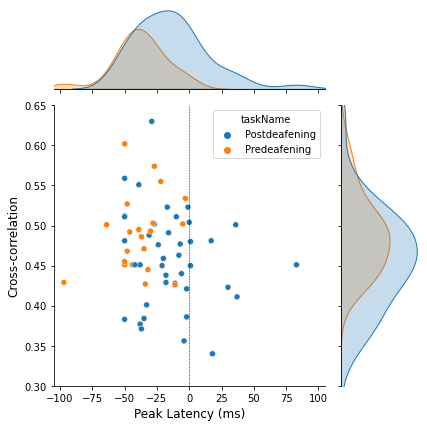

In [10]:
# V1
h = sns.jointplot(x="peakLatency", y="crossCorrMax", data=df,
                  hue='taskName',
#                   s=30, 
                  legend=True, 
                  height=6, ratio=3, 
                  xlim=(-105, 105), ylim=(0.3, 0.65)
                  )

h.set_axis_labels('Peak Latency (ms)', 'Cross-correlation', fontsize=12)
h.ax_joint.axvline(x=0, linestyle = '--', color = 'k', linewidth = 0.5)
plt.show()

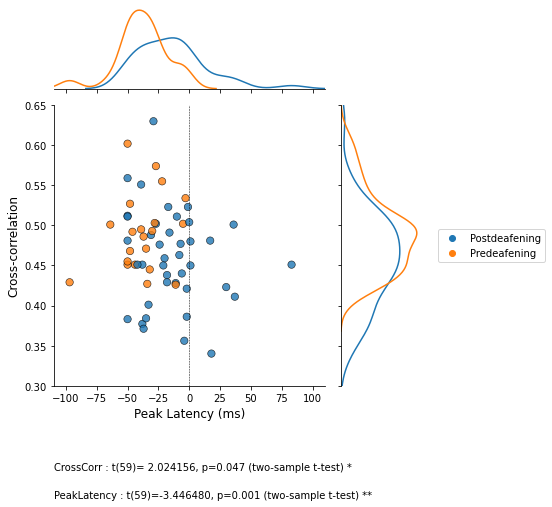

In [11]:
# V2
# Parameters
save_fig = False
fig_ext = '.png'
save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'SongFR_CrossCorr', add_date=False)
fig_size = 6
mark_birds = False  # mark birds with a different marker style
fig_name = 'song_fr_cross_corr'
kernel_bw = 0.4
marker_style = 'birdID' if mark_birds else None

g = sns.JointGrid(x="peakLatency", y="crossCorrMax",  data=df, xlim=(-110, 110), ylim=(0.3, 0.65), height=fig_size, ratio=3)
g.plot_joint(sns.scatterplot, 
             hue='taskName', 
             style=marker_style, 
             s=55, 
             alpha=0.8,
             edgecolor="black",
             # legend='full',
             data=df)

# plot legend on the right
if marker_style:
    handles, labels = g.ax_joint.get_legend_handles_labels()
    order = np.array(range(0, len(labels)))  #specify order of items in legend
    np.put(order, [0, 1, 2], [0, 2, 1])
    g.ax_joint.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc='center left', bbox_to_anchor=(1.4, 0.5)
              ) 
else: 
    g.ax_joint.legend(loc='center left', bbox_to_anchor=(1.4, 0.5)) 

# plot density function
sns.kdeplot(df.loc[df['taskName']=='Postdeafening', 'peakLatency'], ax=g.ax_marg_x, bw=kernel_bw)
sns.kdeplot(df.loc[df['taskName']=='Predeafening', 'peakLatency'], ax=g.ax_marg_x, bw=kernel_bw)
sns.kdeplot(df.loc[df['taskName']=='Postdeafening', 'crossCorrMax'], ax=g.ax_marg_y, vertical=True, bw=kernel_bw)
sns.kdeplot(df.loc[df['taskName']=='Predeafening', 'crossCorrMax'], ax=g.ax_marg_y, vertical=True, bw=kernel_bw)

g.ax_joint.axvline(x=0, linestyle = '--', color = 'k', linewidth = 0.5)
g.set_axis_labels('Peak Latency (ms)', 'Cross-correlation', fontsize=12)

# run stats
from util.stats import two_sample_ttest
pre = df.query('taskName == "Predeafening"')['crossCorrMax']
post = df.query('taskName == "Postdeafening"')['crossCorrMax']
_, _, msg, sig = two_sample_ttest(pre, post)
g.ax_joint.text(0, -0.3, 'CrossCorr : ' + msg + " (two-sample t-test) " + sig, transform=g.ax_joint.transAxes)

pre = df.query('taskName == "Predeafening"')['peakLatency']
post = df.query('taskName == "Postdeafening"')['peakLatency']
_, _, msg, sig = two_sample_ttest(pre, post)
g.ax_joint.text(0, -0.4, 'PeakLatency : ' + msg + " (two-sample t-test) " + sig, transform=g.ax_joint.transAxes)

if save_fig:
    save.save_fig(fig, save_path, fig_name, view_folder=view_folder, fig_ext=fig_ext)
else:
    plt.show()

In [14]:
df.columns

Index(['clusterID', 'nbMotifUndir', 'crossCorrMax', 'peakLatency', 'birdID',
       'taskName', 'block10days'],
      dtype='object')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  31.8952 0.1197  -4.9291 68.7195  False
     0      2  24.2202 0.0251    2.108 46.3325   True
     0      3  14.8095 0.6742 -17.4875 47.1066  False
     0      4  29.5952  0.249 -10.7761 69.9665  False
     1      2   -7.675    0.9  -44.054  28.704  False
     1      3 -17.0857  0.775 -60.4167 26.2453  False
     1      4     -2.3    0.9 -51.9419 47.3419  False
     2      3  -9.4107    0.9 -41.1991 22.3777  False
     2      4    5.375    0.9 -34.5906 45.3406  False
     3      4  14.7857 0.8936 -31.5974 61.1688  False
-----------------------------------------------------


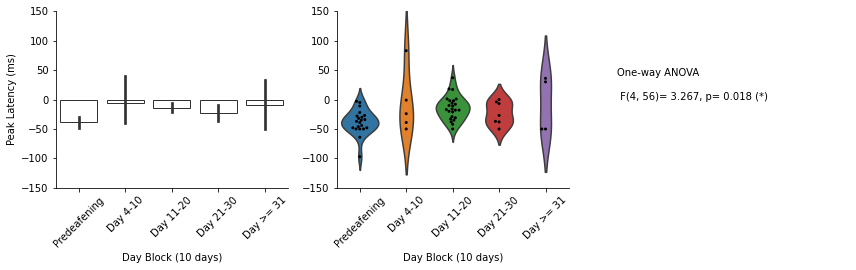

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0125    0.9 -0.0648 0.0898  False
     0      2  -0.0434 0.0777 -0.0898  0.003  False
     0      3  -0.0366 0.5472 -0.1044 0.0312  False
     0      4   0.0011    0.9 -0.0836 0.0859  False
     1      2  -0.0559 0.2497 -0.1323 0.0204  False
     1      3  -0.0491 0.5463 -0.1401 0.0418  False
     1      4  -0.0114    0.9 -0.1156 0.0928  False
     2      3   0.0068    0.9 -0.0599 0.0736  False
     2      4   0.0445 0.5605 -0.0393 0.1284  False
     3      4   0.0377 0.7859 -0.0596 0.1351  False
---------------------------------------------------


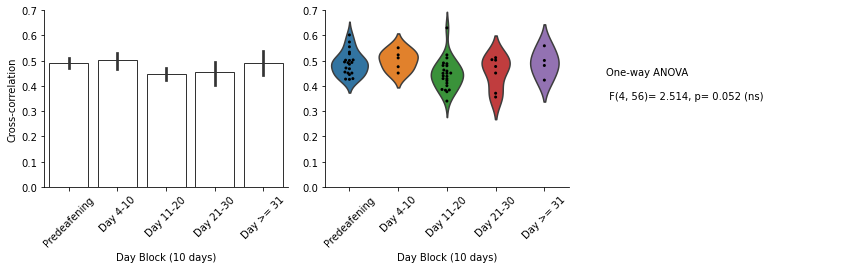

In [22]:
from deafening.plot import plot_per_day_block

# Peak Latency
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='peakLatency',
                   # title=f'Syllable Entropy (Undir) per day block',
                   y_label='Peak Latency (ms)',
                   y_lim=[-150, 150],
                   post_hoc=True,
                   fig_name='SongFRCrossCorr_PeakLatency',
                   save_fig=False, fig_ext='.png'
                   )

# Peak Latency
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='crossCorrMax',
                   # title=f'Syllable Entropy (Undir) per day block',
                   y_label='Cross-correlation',
                   y_lim=[0, 0.7],
                   post_hoc=True,
                   fig_name='SongFRCrossCorr',
                   save_fig=False, fig_ext='.png'
                   )